In [1]:
!pip install timm



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from timm import create_model
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


c:\Users\pravi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📟 Device: {device}")


📟 Device: cuda


In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


In [5]:
train_dir = "dataset_vit_aug/train"
test_dir = "dataset_vit/test"

train_dataset = ImageFolder(train_dir, transform=train_transform)
test_dataset = ImageFolder(test_dir, transform=test_transform)

print(f"📊 Train: {len(train_dataset)} | Test: {len(test_dataset)}")
print(f"📂 Classes: {train_dataset.classes}")


📊 Train: 150992 | Test: 33335
📂 Classes: ['A', 'AFIB', 'AFL', 'L', 'N', 'R', 'V']


In [6]:
from torch.utils.data import random_split

train_size = int(0.85 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

print(f"🟢 Train: {len(train_set)} | 🟡 Val: {len(val_set)}")


🟢 Train: 128343 | 🟡 Val: 22649


In [7]:
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


In [8]:
model = create_model("deit_base_patch16_224", pretrained=True, num_classes=0)  # No default head
model.head = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.num_features, len(train_dataset.classes))
)
model = model.to(device)
print("✅ DeiT model dengan tuning siap di GPU")


✅ DeiT model dengan tuning siap di GPU


In [9]:
from tqdm import tqdm
import time

num_epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scaler = GradScaler()


C:\Users\pravi\AppData\Local\Temp\ipykernel_6720\2037770196.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [10]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0
    start_time = time.time()

    loop = tqdm(train_loader, desc=f"🚀 Epoch [{epoch+1}/{num_epochs}]")

    for images, labels in loop:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

        loop.set_postfix(loss=loss.item())

    acc = correct / total_samples * 100
    avg_loss = total_loss / len(train_loader)
    mins, secs = divmod(time.time() - start_time, 60)
    print(f"✅ Epoch {epoch+1} selesai - Loss: {avg_loss:.4f} - 🎯 Akurasi: {acc:.2f}% - ⏱️ Durasi: {int(mins)}m {int(secs)}s")
    print(f"📈 GPU Mem Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")


🚀 Epoch [1/5]:   0%|          | 0/4011 [00:00<?, ?it/s]C:\Users\pravi\AppData\Local\Temp\ipykernel_6720\3702559720.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
🚀 Epoch [1/5]: 100%|██████████| 4011/4011 [29:31<00:00,  2.26it/s, loss=0.0187] 


✅ Epoch 1 selesai - Loss: 0.1082 - 🎯 Akurasi: 96.61% - ⏱️ Durasi: 29m 31s
📈 GPU Mem Used: 1341.49 MB


🚀 Epoch [2/5]: 100%|██████████| 4011/4011 [29:27<00:00,  2.27it/s, loss=0.0546]  


✅ Epoch 2 selesai - Loss: 0.0602 - 🎯 Akurasi: 98.09% - ⏱️ Durasi: 29m 27s
📈 GPU Mem Used: 1341.49 MB


🚀 Epoch [3/5]: 100%|██████████| 4011/4011 [28:36<00:00,  2.34it/s, loss=0.00501] 


✅ Epoch 3 selesai - Loss: 0.0475 - 🎯 Akurasi: 98.50% - ⏱️ Durasi: 28m 36s
📈 GPU Mem Used: 1341.49 MB


🚀 Epoch [4/5]: 100%|██████████| 4011/4011 [28:29<00:00,  2.35it/s, loss=0.326]   


✅ Epoch 4 selesai - Loss: 0.0411 - 🎯 Akurasi: 98.69% - ⏱️ Durasi: 28m 29s
📈 GPU Mem Used: 1341.49 MB


🚀 Epoch [5/5]: 100%|██████████| 4011/4011 [28:31<00:00,  2.34it/s, loss=0.000858]

✅ Epoch 5 selesai - Loss: 0.0368 - 🎯 Akurasi: 98.80% - ⏱️ Durasi: 28m 31s
📈 GPU Mem Used: 1341.49 MB


In [11]:
class_names = train_dataset.classes
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
cm = confusion_matrix(y_true, y_pred)


In [12]:
def calculate_specificity(cm):
    specificity = []
    for i in range(len(cm)):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(np.delete(cm[:, i], i))
        specificity.append(tn / (tn + fp + 1e-8))
    return specificity

def calculate_per_class_accuracy(cm):
    accuracy = []
    for i in range(len(cm)):
        tp = cm[i, i]
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)
        accuracy.append(acc)
    return accuracy

specificities = calculate_specificity(cm)
accuracies = calculate_per_class_accuracy(cm)


In [13]:
print(f"{'Class':<10} {'Accuracy':>10} {'Precision':>10} {'Sensitivity':>12} {'Specificity':>12} {'F1-Score':>10}")
for idx, cls in enumerate(class_names):
    acc = accuracies[idx] * 100
    prec = report[cls]['precision'] * 100
    sens = report[cls]['recall'] * 100
    spec = specificities[idx] * 100
    f1 = report[cls]['f1-score'] * 100
    print(f"{cls:<10} {acc:10.2f} {prec:10.2f} {sens:12.2f} {spec:12.2f} {f1:10.2f}")


Class        Accuracy  Precision  Sensitivity  Specificity   F1-Score
A               99.34      81.53        91.88        99.51      86.40
AFIB            99.97      99.66       100.00        99.96      99.83
AFL             99.97     100.00        78.43       100.00      87.91
L               99.87      99.21        98.93        99.94      99.07
N               98.92      99.67        98.72        99.33      99.19
R               99.92      99.04        99.72        99.93      99.38
V               99.46      93.55        98.36        99.54      95.90


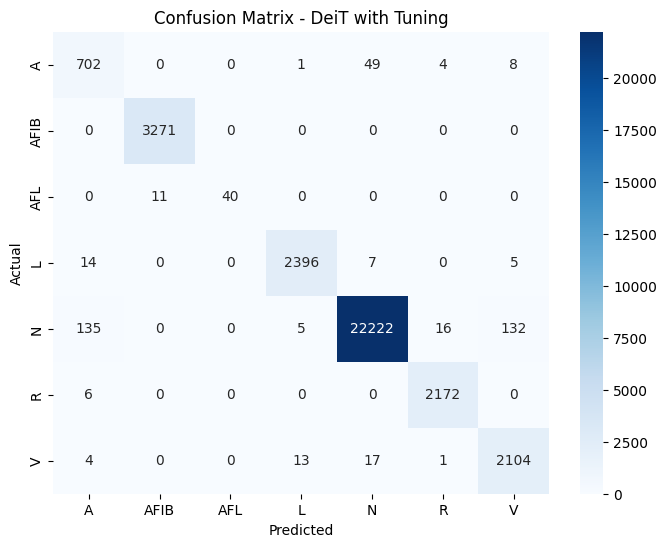

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - DeiT with Tuning")
plt.show()


In [15]:
torch.save(model.state_dict(), "model_deit_tuning.pth")
print("📦 Model DeiT berhasil disimpan!")


📦 Model DeiT berhasil disimpan!
